#**Artificial occlusion of face images**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/CodeNexus

/content/drive/My Drive/CodeNexus


In [5]:
!pip install face_alignment --quiet

In [6]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from landmarks_helper_cpu import LandmarksHelper
from tqdm.notebook import tqdm
import os, shutil, copy
import random
import glob
import PIL
import zipfile
from PIL import Image
import io
from collections import Counter
import face_alignment
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D)
landmarksHelper = LandmarksHelper()

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


  0%|          | 0.00/85.7M [00:00<?, ?B/s]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip


  0%|          | 0.00/91.9M [00:00<?, ?B/s]

#**Define functions**

In [7]:
def resize_img(image):
    h, w = image.shape[:2]
    resized = False
    if h > 1000 or w > 1000:
        resized = True
        if h>w:
            image = cv2.resize(image, (int(w*1000/h), 1000))
        elif h<w:
            image = cv2.resize(image, (1000, int(h*1000/w)))
        else:
            image = cv2.resize(image, (1000, 1000))
    return resized, image


def remap_bbox(small_image, big_image, small_bbox): # This func remaps the bounding box to original frame length
    old_y, old_x = small_image.shape[:2] # Get resized frame height and width
    new_y, new_x = big_image.shape[:2] # Get original frame height and width

    # Get remapped bounding box
    new_bbox = [int(cord*new_x/old_x) if idx%2==0 else int(cord*new_y/old_y) for idx, cord in enumerate(small_bbox)]
    # return bb_to_rect(new_bbox)
    return new_bbox
    

def remap_landmarks(small_image, big_image, small_landmarks): # This func remaps the bounding box to original frame length
    old_y, old_x = small_image.shape[:2] # Get resized frame height and width
    new_y, new_x = big_image.shape[:2] # Get original frame height and width
    
    # Get remapped bounding box
    new_landmarks = [(int(cord[0]*new_x/old_x), int(cord[1]*new_y/old_y)) for idx, cord in enumerate(small_landmarks)]
    return new_landmarks
    
    
def get_landmarks(image, draw_on_image = False):
    
    resized, small_image = resize_img(image)
    preds = fa.get_landmarks_from_image(small_image)
    bboxes = fa.face_detector.detect_from_image(small_image[..., ::-1].copy())
    
    landmarks = []
    boxes = []
    
    for i, (landmark, box) in enumerate(zip(preds, bboxes)):
      
      if resized:
        landmark = remap_landmarks(small_image, image, landmark)
        box = remap_bbox(small_image, image, box)
        
      landmarks.append(landmark)
      boxes.append([box[0], box[1], box[2], box[3]])
      if draw_on_image:
          # cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
          
          # cv2.putText(image, "Face #{}".format(i + 1), (int(box[0]) - 10, int(box[1]) - 10),
          #     cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
          
          circle_size = 9 if image.shape[0] > 2000 else 7
          
          for (x, y) in landmark:
              cv2.circle(image, (int(x), int(y)), 1, (0, 0, 255), circle_size)
    
    return landmarks, boxes


def get_cropped_image(image, boxes, extend_by_percent_of_width=0.5): # Perform crop extension
    boxes = [max(int(boxes[0]), 0), max(int(boxes[1]), 0), min(int(boxes[2]), image.shape[1]), min(int(boxes[3]), image.shape[0])]
    width_of_box = boxes[2] - boxes[0]
    extend_by = width_of_box*extend_by_percent_of_width
    xmin = max(boxes[0]-extend_by, 0)
    xmax = min(boxes[2]+extend_by, image.shape[1])
    ymin = max(boxes[1]-extend_by, 0)
    ymax = min(boxes[3]+extend_by, image.shape[0])
    new_boxes = [xmin, ymin, xmax, ymax]
    cropped_image = image[int(new_boxes[1]):int(new_boxes[3]), int(new_boxes[0]):int(new_boxes[2])]
    return cropped_image, new_boxes

In [8]:
def get_edges_contours(image_grey, canny_low = 100, canny_high = 400):
  edges = cv2.Canny(image_grey, canny_low, canny_high)
  edges = cv2.dilate(edges, None)
  edges = cv2.erode(edges, None)
  contour_info = [(c, cv2.contourArea(c),) for c in cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]]
  return edges, contour_info

def remove_background(image):
  
  blurred = cv2.GaussianBlur(image, (5, 5), 0)
  gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
  ret, gray = cv2.threshold(gray, 210 , 255, cv2.CHAIN_APPROX_NONE)
  gray = gray.astype(np.uint8)
  contours, hierarchy = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contour = max(contours, key=cv2.contourArea)
  # image_contour = np.copy(image)
  # cont_img = cv2.drawContours(image_contour, [contour], 0, (255, 0, 0), 2, cv2.LINE_AA, maxLevel=1)
  # cv2_imshow(cont_img)

  mask = np.zeros_like(gray)
  cv2.fillPoly(mask, [contour], 255)
  res_mask = np.copy(mask)
  res_mask[mask == 0] = cv2.GC_BGD # obvious background pixels
  res_mask[mask == 255] = cv2.GC_PR_BGD # probable background pixels
  res_mask[mask == 255] = cv2.GC_FGD # obvious foreground pixels

  mask2 = np.where((res_mask == cv2.GC_FGD) | (res_mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')
  kernel_size = (3,3)
  kernel_el = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
  mask2 = cv2.erode(mask2, kernel_el, (-1,-1))
  mask2 = cv2.dilate(mask2, kernel_el, (-1,-1))
  # mask2 = cv2.erode(mask2, kernel_el, (-1,-1))
  # mask2 = cv2.GaussianBlur(mask2, (3,3), 0)

  image[image==255] = 0

  # Make background transparent to allow overlay on faces
  image = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)
  image[mask2==0] = 0

  # image = cv2.GaussianBlur(image, (3,3), 0)

  x = np.min(np.where(mask2==255)[0])
  w = np.max(np.where(mask2==255)[0])
  y = np.min(np.where(mask2==255)[1])
  h = np.max(np.where(mask2==255)[1])

  image = image[x:w, y:h]

  return image


In [17]:
def get_average_colours(img):
  try:  # 4D img
    norm = img.shape[0] * img.shape[1]/len(img[np.where(img[:,:,3]!=0)])
  except: # 3D img
    norm = 1
  r = np.mean(img[:,:,0])*norm
  g = np.mean(img[:,:,1])*norm
  b = np.mean(img[:,:,2])*norm
  return r, g, b


def match_face_skin_tone(face, landmarks, body, mask):

  # Recolour hand to match skin tone
  # Get area to measure skin tone between landmarks
  #     1       15
  #     2       14
  lm1 = landmarks[0][1]
  lm15 = landmarks[0][15]
  lm2 = landmarks[0][2]
  lm14 = landmarks[0][14]
  img_section = face[int(lm1[1]):int(lm2[1]), int(lm2[0]):int(lm14[0])]

  # Get average face colours
  avg_r, avg_g, avg_b = get_average_colours(img_section)

  # Get average hand colours
  avg_r_h, avg_g_h, avg_b_h = get_average_colours(body)

  r_dist = avg_r/avg_r_h
  g_dist = avg_g/avg_g_h
  b_dist = avg_b/avg_b_h

  body_copy = np.copy(body)
  body = np.array(body, dtype = np.float32)
  body[:,:,0]*=r_dist
  body[:,:,1]*=g_dist
  body[:,:,2]*=b_dist
  body[np.where(body>255)] = 255
  body[np.where(body<=0)] = 0
  body = np.array(body, dtype = np.uint8)
  body[(body_copy==0) & (mask==0)] = body_copy[(body_copy==0) & (mask==0)]

  return body


def make_width(image, width):
  height = image.shape[0] * width/image.shape[1]
  dim = (int(width), int(height))   # (w,h)
  image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  return image


def make_height(image, height):
  width = image.shape[1] * height/image.shape[0]
  dim = (int(width), int(height))   # (w,h)
  image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  return image


def rotate(image, angle_range):
  angle = random.randint(angle_range[0], angle_range[1])

  height, width = image.shape[:2] # image shape has 3 dimensions
  image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

  rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

  # rotation calculates the cos and sin, taking absolutes of those.
  abs_cos = abs(rotation_mat[0,0]) 
  abs_sin = abs(rotation_mat[0,1])

  # find the new width and height bounds
  bound_w = int(height * abs_sin + width * abs_cos)
  bound_h = int(height * abs_cos + width * abs_sin)

  # subtract old image center (bringing image back to origo) and adding the new image center coordinates
  rotation_mat[0, 2] += bound_w/2 - image_center[0]
  rotation_mat[1, 2] += bound_h/2 - image_center[1]

  # rotate image with the new bounds and translated rotation matrix
  rotated_mat = cv2.warpAffine(image, rotation_mat, (bound_w, bound_h))

  mask = np.ones(rotated_mat.shape)*255
  mask[rotated_mat[:,:,3]==0] = 0
  kernel_size = (6,6)
  kernel_el = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
  # mask = cv2.erode(mask, kernel_el)
  # mask = cv2.dilate(mask, kernel_el)
  # mask = cv2.erode(mask, kernel_el)
  # mask = cv2.dilate(mask, kernel_el)
  mask = cv2.erode(mask, kernel_el)
  rotated_mat[mask==0]=0

  return rotated_mat, mask
  

def place_on_face(face, obj, landmarks, landmark_id):

  face_obj = cv2.cvtColor(face, cv2.COLOR_RGB2RGBA)
  
  lm = landmarks[0][landmark_id]  # x from right, y from bottom

  left = int(lm[0] - obj.shape[1]/2)
  top = int(lm[1] - obj.shape[0]/2)

  blank = np.zeros((face_obj.shape[0]+2*obj.shape[0], face_obj.shape[1]+2*obj.shape[1], face_obj.shape[2]))
  blank[top+obj.shape[0]:top+2*obj.shape[0], left+obj.shape[1]:left+2*obj.shape[1]] = obj
  blank = blank[obj.shape[0]:-obj.shape[0], obj.shape[1]:-obj.shape[1]]

  face_obj[np.where(blank!=0)]=blank[np.where(blank!=0)]
  return face_obj


def get_cropped_image(image, boxes, extend_by_percent_of_width=0.5): # Perform crop extension
    boxes = [max(int(boxes[0]), 0), max(int(boxes[1]), 0), min(int(boxes[2]), image.shape[1]), min(int(boxes[3]), image.shape[0])]
    width_of_box = boxes[2] - boxes[0]
    extend_by = width_of_box*extend_by_percent_of_width
    xmin = max(boxes[0]-extend_by, 0)
    xmax = min(boxes[2]+extend_by, image.shape[1])
    ymin = max(boxes[1]-extend_by, 0)
    ymax = min(boxes[3]+extend_by, image.shape[0])
    new_boxes = [xmin, ymin, xmax, ymax]
    cropped_image = image[int(new_boxes[1]):int(new_boxes[3]), int(new_boxes[0]):int(new_boxes[2])]
    return cropped_image, new_boxes


In [10]:
def insert_glasses(face, glass, landmarks):
  face_width = (landmarks[0][26][0] - landmarks[0][17][0])*1.2
  lm_id = 27
  glass = make_width(glass, face_width)
  glasses_face = place_on_face(face, glass, landmarks, lm_id)
  return glasses_face

def insert_phone(face, phone, landmarks):
  phone_height = (landmarks[0][8][1] - landmarks[0][27][1])*1.1
  phone = make_height(phone, phone_height)
  max_rot_angle = 40
  lm_id = random.choice([2, 14])
  if lm_id == 2:   # Angle of rotation depends on side of face
    phone = rotate(phone, angle_range=(int(-0.15*max_rot_angle),int(max_rot_angle)))
  else:
    phone = rotate(phone, angle_range=(int(-max_rot_angle),int(0.15*max_rot_angle)))
  phone_face = place_on_face(face, phone, landmarks, lm_id)
  return phone_face

def insert_eyepatch(face, eyepatch, landmarks):
  face_width = (landmarks[0][16][0] - landmarks[0][20][0])*1.3
  lm_id = random.choice([39, 42])
  if lm_id == 39:
    eyepatch = cv2.flip(eyepatch, 1)    # Flip eyepatch to left eye
  eyepatch = make_width(eyepatch, face_width)
  eyepatch_face = place_on_face(face, eyepatch, landmarks, lm_id)
  return eyepatch_face

def insert_hand(face, hand, hwf, landmarks, hand_locations):
  hand_width = (landmarks[0][15][0] - landmarks[0][1][0])*hwf
  lm_id = random.choice(hand_locations)
  # Lists containing which landmarks are on the lhs/rhs of face
  lhs = sum([list(range(0,8)), list(range(17,22)), list(range(36,42)), list(range(58,62)), [31, 32, 48, 49, 50, 67]], [])
  rhs = sum([list(range(9,17)), list(range(22,27)), list(range(42,48)), list(range(52,57)), [34, 35, 63, 64, 65]], [])
  if random.random() >= 0.5:
    hand = cv2.flip(hand, 1)    # Flip hand
  if lm_id in lhs:
    if 0<=lm_id<=5:
      angle_range = (240, 300)
    elif 6<=lm_id<=7:
      angle_range = (320, 360)
    elif 17<=lm_id<=21:
       angle_range = (180, 230) 
    else:
      angle_range = (180,360)
  elif lm_id in rhs:
    if 11<=lm_id<=16:
      angle_range = (60, 120)
    elif 9<=lm_id<=10:
      angle_range = (0, 40)
    elif 17<=lm_id<=21:
       angle_range = (130, 180)
    else:
      angle_range = (0, 180)
  hand = make_width(hand, hand_width)
  hand, mask = rotate(hand, angle_range)  
  hand = match_face_skin_tone(face, landmarks, hand, mask)  
  hand_face = place_on_face(face, hand, landmarks, lm_id)
  return hand_face

def insert_hand_small(face, hand, landmarks):
  hand_width_factor = 0.45
  hand_locations = sum([list(range(0,8)), list(range(9,17))], [])
  hand_face = insert_hand(face, hand, hand_width_factor, landmarks, hand_locations)
  return hand_face

def insert_hand_medium(face, hand, landmarks):
  hand_width_factor = 0.65
  hand_locations = sum([list(range(0,8)), list(range(9,18)), [26]], []) #[36, 45, 48, 49, 53, 54, 55, 59, 60, 64]], [])
  hand_face = insert_hand(face, hand, hand_width_factor, landmarks, hand_locations)
  return hand_face

def insert_hand_large(face, hand, landmarks):
  hand_width_factor = 0.85
  hand_locations = sum([list(range(36,51)), list(range(52,57)), list(range(58,62)), [31, 32, 34, 35, 63, 64, 65, 67]], [])
  hand_face = insert_hand(face, hand, hand_width_factor, landmarks, hand_locations)
  return hand_face

#**Comparison of face landmark detection libraries**

Choose random image to compare.
Face alignment is more accurate, and so should be used on the selfies dataset.

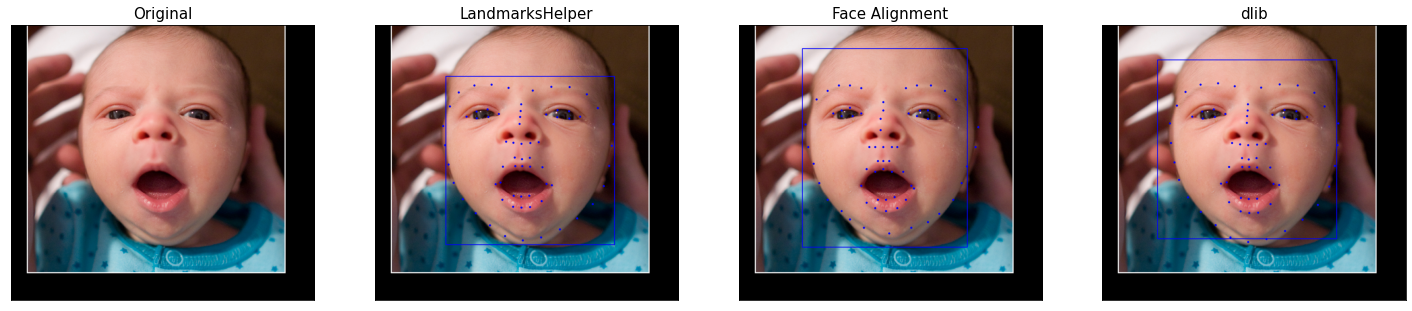

In [ ]:
# img = cv2.imread('300W_cropped/01_Indoor/indoor_104.png')
img = cv2.imread('300W_cropped/01_Indoor/indoor_116.png')

lh_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fa_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dl_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

lh_landmarks, lh_boxes = landmarksHelper.get_landmarks(lh_img)
fa_landmarks, fa_boxes = get_landmarks(fa_img)
dl_landmarks, dl_boxes = dlib_landmarks(dl_img)

circle_size = 5
cv2.rectangle(lh_img, (int(lh_boxes[0][0]), int(lh_boxes[0][1])), (int(lh_boxes[0][2]), int(lh_boxes[0][3])), (0, 0, 255), 2)         
for (x, y) in lh_landmarks[0]:
    cv2.circle(lh_img, (int(x), int(y)), 1, (0, 0, 255), circle_size)

cv2.rectangle(fa_img, (int(fa_boxes[0][0]), int(fa_boxes[0][1])), (int(fa_boxes[0][2]), int(fa_boxes[0][3])), (0, 0, 255), 2)
for (x, y) in fa_landmarks[0]:
    cv2.circle(fa_img, (int(x), int(y)), 1, (0, 0, 255), circle_size)

cv2.rectangle(dl_img, (int(dl_boxes[0][0]), int(dl_boxes[0][1])), (int(dl_boxes[0][2]), int(dl_boxes[0][3])), (0, 0, 255), 2)         
for (x, y) in dl_landmarks[0]:
    cv2.circle(dl_img, (int(x), int(y)), 1, (0, 0, 255), circle_size)


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
lh_img = Image.fromarray(lh_img)
fa_img = Image.fromarray(fa_img)
dl_img = Image.fromarray(dl_img)
  
fig, ax = plt.subplots(1, 4, figsize=(25,10))
ax[0].set_title('Original', fontsize=15)
ax[0].imshow(img)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].set_title('LandmarksHelper', fontsize=15)
ax[1].imshow(lh_img)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].set_title('Face Alignment', fontsize=15)
ax[2].imshow(fa_img)
ax[2].set_xticks([])
ax[2].set_yticks([])

ax[3].set_title('dlib', fontsize=15)
ax[3].imshow(dl_img)
ax[3].set_xticks([])
ax[3].set_yticks([])
plt.show()

#**Load and test faces and occlusion objects**

In [11]:
faces = []
for img in os.listdir('OcclusionImages/faces'):
  faces.append(cv2.imread(os.path.join('OcclusionImages/faces', img)))
  
# eyepatches = []
# for img in os.listdir('OcclusionImages/eyepatches'):
#   eyepatch = cv2.imread(os.path.join('OcclusionImages/eyepatches', img))
#   eyepatches.append(remove_background(eyepatch))

hands = []
for img in sorted(os.listdir('OcclusionImages/hands')):
  hand = cv2.imread(os.path.join('OcclusionImages/hands', img))
  hands.append(remove_background(hand))

# phones = []
# for img in os.listdir('OcclusionImages/phones'):
#   phone = cv2.imread(os.path.join('OcclusionImages/phones', img))
#   phones.append(remove_background(phone))

# glasses = []
# for img in os.listdir('OcclusionImages/glasses'):
#   glass = cv2.imread(os.path.join('OcclusionImages/glasses', img))
#   glasses.append(remove_background(glass))

# sunglasses = []
# for img in os.listdir('OcclusionImages/sunglasses'):
#   sunglass = cv2.imread(os.path.join('OcclusionImages/sunglasses', img))
#   sunglasses.append(remove_background(sunglass))

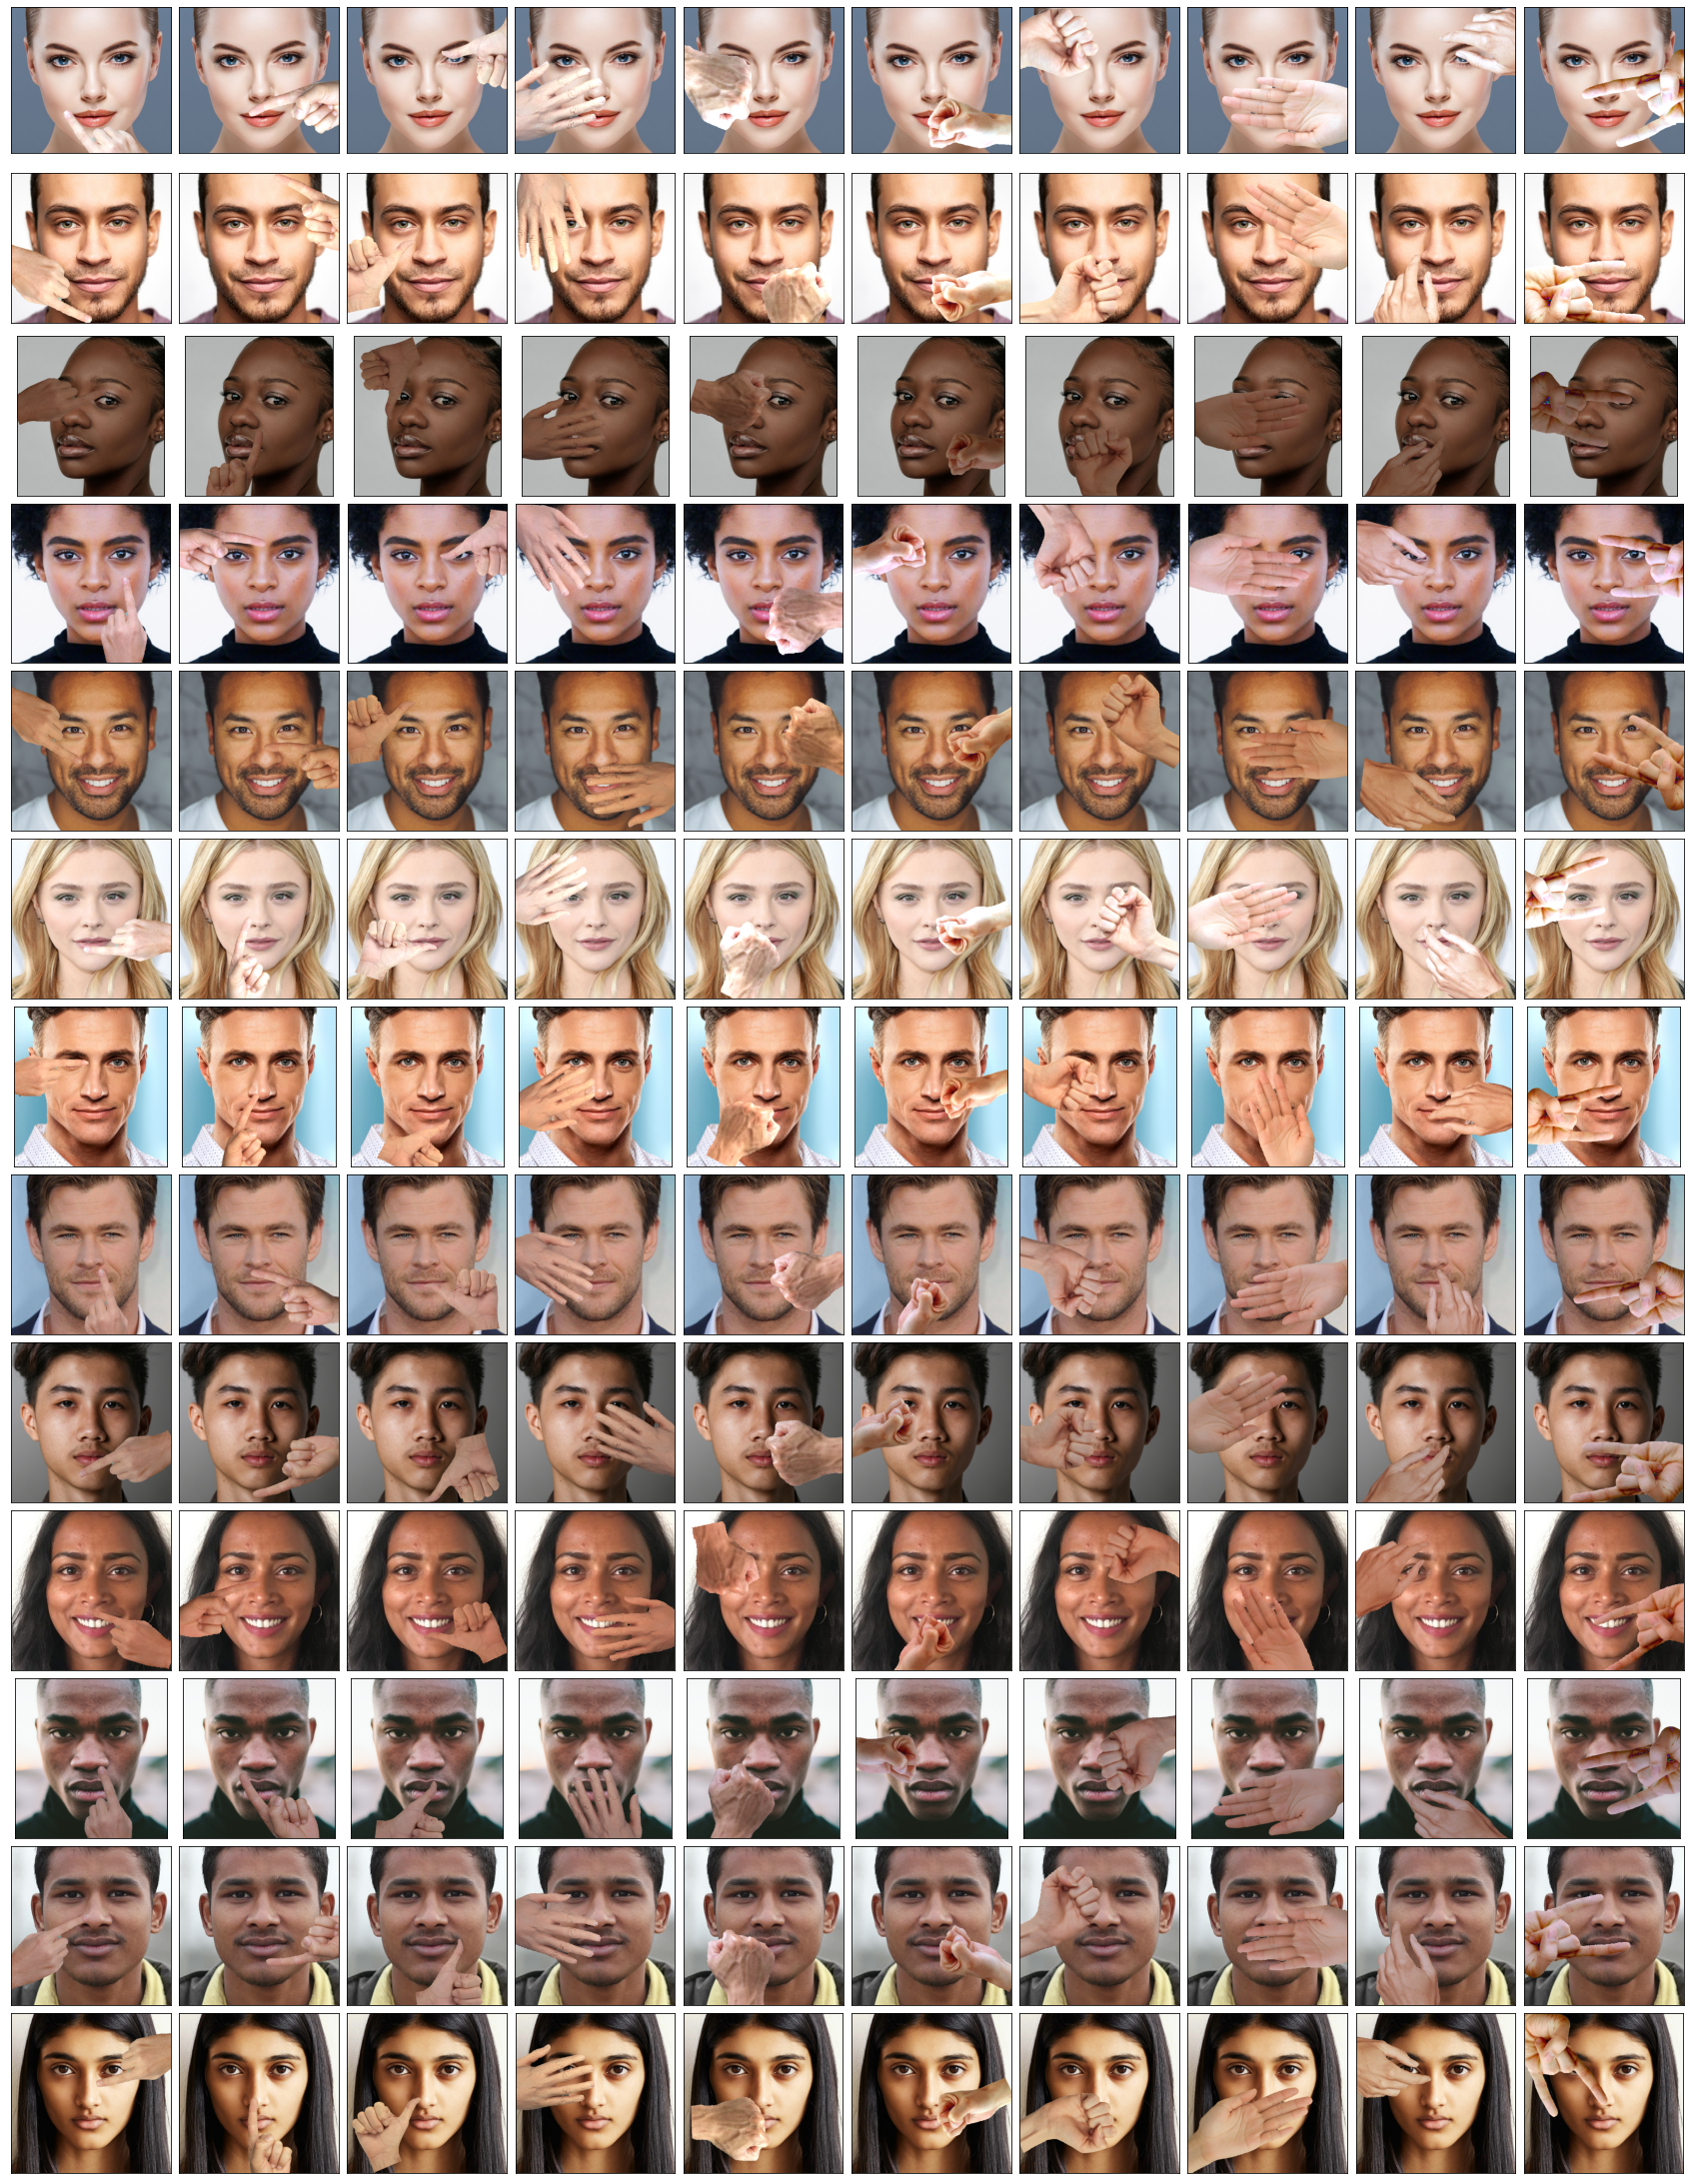

In [10]:
fig, ax = plt.subplots(len(faces), 10, figsize=(30,40))
fig.subplots_adjust(wspace=0.05, hspace=0.05)

for i, face in enumerate(faces):

  landmarks, boxes = landmarksHelper.get_landmarks(face)

#   # glass = random.choice(glasses)
#   # gf = insert_glasses(face, glass, landmarks)
#   # gf, nb = get_cropped_image(gf, boxes[0], 0.2)

#   # sunglass = random.choice(sunglasses)
#   # sgf = insert_glasses(face, sunglass, landmarks)
#   # sgf, nb = get_cropped_image(sgf, boxes[0], 0.2)

#   # phone = random.choice(phones)
#   # pf = insert_phone(face, phone, landmarks)
#   # pf, nb = get_cropped_image(pf, boxes[0])

#   # eyepatch = random.choice(eyepatches)
#   # ef = insert_eyepatch(face, eyepatch, landmarks)
#   # ef, nb = get_cropped_image(ef, boxes[0])


  # Light occlusions
  hand = hands[0]
  hf0 = insert_hand_small(face, hand, landmarks)
  hf0, nb = get_cropped_image(hf0, boxes[0], 0.2)

  hand = hands[1]
  hf1 = insert_hand_small(face, hand, landmarks)
  hf1, nb = get_cropped_image(hf1, boxes[0], 0.2)

  hand = hands[2]
  hf2 = insert_hand_medium(face, hand, landmarks)
  hf2, nb = get_cropped_image(hf2, boxes[0], 0.2)

 
  # Heavy occlusions
  hand = hands[3]
  hf3 = insert_hand_medium(face, hand, landmarks)
  hf3, nb = get_cropped_image(hf3, boxes[0], 0.2)

  hand = hands[4]
  hf4 = insert_hand_medium(face, hand, landmarks)
  hf4, nb = get_cropped_image(hf4, boxes[0], 0.2)

  hand = hands[5]
  hf5 = insert_hand_small(face, hand, landmarks)
  hf5, nb = get_cropped_image(hf5, boxes[0], 0.2)

  hand = hands[6]
  hf6 = insert_hand_medium(face, hand, landmarks)
  hf6, nb = get_cropped_image(hf6, boxes[0], 0.2)

  hand = hands[7]
  hf7 = insert_hand_medium(face, hand, landmarks)
  hf7, nb = get_cropped_image(hf7, boxes[0], 0.2)

  hand = hands[8]
  hf8 = insert_hand_medium(face, hand, landmarks)
  hf8, nb = get_cropped_image(hf8, boxes[0], 0.2)

  hand = hands[9]
  hf9 = insert_hand_medium(face, hand, landmarks)
  hf9, nb = get_cropped_image(hf9, boxes[0], 0.2) 

  ax[i,0].imshow(cv2.cvtColor(hf0, cv2.COLOR_BGR2RGB))
  ax[i,1].imshow(cv2.cvtColor(hf1, cv2.COLOR_BGR2RGB))
  ax[i,2].imshow(cv2.cvtColor(hf2, cv2.COLOR_BGR2RGB))
  ax[i,3].imshow(cv2.cvtColor(hf3, cv2.COLOR_BGR2RGB))
  ax[i,4].imshow(cv2.cvtColor(hf4, cv2.COLOR_BGR2RGB))
  ax[i,5].imshow(cv2.cvtColor(hf5, cv2.COLOR_BGR2RGB))
  ax[i,6].imshow(cv2.cvtColor(hf6, cv2.COLOR_BGR2RGB))
  ax[i,7].imshow(cv2.cvtColor(hf7, cv2.COLOR_BGR2RGB))
  ax[i,8].imshow(cv2.cvtColor(hf8, cv2.COLOR_BGR2RGB))
  ax[i,9].imshow(cv2.cvtColor(hf9, cv2.COLOR_BGR2RGB))

  for j in range(10):
    ax[i,j].set_xticks([])

  for j in range(10):
    ax[i,j].set_yticks([])

plt.show()

#**Create dataset**

In [95]:
# # Process HQ Processed files to extract crops

# def get_names(txt_file):
#     with open(txt_file, 'r') as f:
#         names = f.read()
#         names = names.split('\n')
#     return names[:-1]
    
# files = os.listdir('hqprocessed')
# files = [file for file in files if 'txt' in file]

# print(files)

# for file in files:
#     folder = os.path.join('hqprocessed/hqprocessed-'+file.replace('.txt', ''), 'real')
#     crops_folder = os.path.join(folder, 'crops')
#     depths_folder = os.path.join(folder, 'depths')
#     crops_names = os.listdir(crops_folder)
#     depths_names = os.listdir(depths_folder)
#     names_to_keep = get_names(os.path.join('hqprocessed', file))
#     names_to_delete = [name for name in crops_names if name not in names_to_keep]
#     for name in tqdm(crops_names):
#         if name not in names_to_keep:
#             os.remove(os.path.join(crops_folder, name))
#             os.remove(os.path.join(depths_folder, name))

In [20]:
tot = 0
for base_folder in folders:
  try:
    path = os.path.join('hqprocessed', base_folder, 'real', 'crops')
    print(path, len(os.listdir(path)))
    tot += len(os.listdir(path))
  except: 
    None
print(tot, 'total hqprocessed crops.')

hqprocessed/hqprocessed-25000-30000/real/crops 2024
hqprocessed/hqprocessed-30000-35000/real/crops 1634
hqprocessed/hqprocessed-35000-40000/real/crops 2047
hqprocessed/hqprocessed-40000-45000/real/crops 2468
hqprocessed/hqprocessed-8000-15000/real/crops 2580
10753 total hqprocessed crops.


**Add hands to hqprocessed images**

In [16]:
folders = os.listdir('hqprocessed')
folders = [folder for folder in folders if 'txt' not in folder]

finger_i = 0
thumb_i = 0
hand_i = 0

for base_folder in folders:
  path = os.path.join('hqprocessed', base_folder, 'real', 'crops')
  for filename in tqdm(os.listdir(path)):
    try:
      face = cv2.imread(os.path.join(path, filename))     
      landmarks, boxes = landmarksHelper.get_landmarks(face)

      rand_light = random.randint(0,2)
      light_hand = hands[rand_light]
      if rand_light == 2:
        light_hand = insert_hand_medium(face, light_hand, landmarks)
        light_hand, nb = get_cropped_image(light_hand, boxes[0], 0.2)
        cv2.imwrite(f'OcclusionImages/ArtificialOcclusionDataset/3/hqp_added_thumbs/thumb_{thumb_i}.jpg', light_hand)
        thumb_i+=1
      else:
        light_hand = insert_hand_small(face, light_hand, landmarks)
        light_hand, nb = get_cropped_image(light_hand, boxes[0], 0.2)
        cv2.imwrite(f'OcclusionImages/ArtificialOcclusionDataset/3/hqp_added_fingers/finger_{finger_i}.jpg', light_hand)
        finger_i+=1

      rand_heavy = random.randint(3,9)
      heavy_hand = hands[rand_heavy]
      if rand_heavy == 5:
        heavy_hand = insert_hand_small(face, heavy_hand, landmarks)
      else:
        heavy_hand = insert_hand_medium(face, heavy_hand, landmarks)
      heavy_hand, nb = get_cropped_image(heavy_hand, boxes[0], 0.2)
      cv2.imwrite(f'OcclusionImages/ArtificialOcclusionDataset/4/hqp_added_hands/hand_{hand_i}.jpg', heavy_hand)
      hand_i+=1

    except:
      None # Face is missing landmarks


  0%|          | 0/2024 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/1634 [00:00<?, ?it/s]

  0%|          | 0/2047 [00:00<?, ?it/s]

  0%|          | 0/2468 [00:00<?, ?it/s]

  0%|          | 0/2580 [00:00<?, ?it/s]

**Add hands to selfies dataset images**

In [21]:
finger_i = 0
thumb_i = 0
hand_i = 0

folders = ['OcclusionImages/ArtificialOcclusionDataset/0/cleaned_selfies_0',
           'OcclusionImages/ArtificialOcclusionDataset/1/cleaned_selfies_1',
           'OcclusionImages/ArtificialOcclusionDataset/2/cleaned_selfies_2']

for folder in folders:
  for filename in tqdm(os.listdir(folder)):
    try:
      face = cv2.imread(os.path.join(folder, filename))     
      landmarks, boxes = get_landmarks(face)

      rand_light = random.randint(0,2)
      light_hand = hands[rand_light]
      if rand_light == 2:
        light_hand = insert_hand_medium(face, light_hand, landmarks)
        cv2.imwrite(f'OcclusionImages/ArtificialOcclusionDataset/3/selfies_added_thumbs/thumb_{thumb_i}.jpg', light_hand)
        thumb_i+=1
      else:
        light_hand = insert_hand_small(face, light_hand, landmarks)
        cv2.imwrite(f'OcclusionImages/ArtificialOcclusionDataset/3/selfies_added_fingers/finger_{finger_i}.jpg', light_hand)
        finger_i+=1

      rand_heavy = random.randint(3,9)
      heavy_hand = hands[rand_heavy]
      if rand_heavy == 5:
        heavy_hand = insert_hand_small(face, heavy_hand, landmarks)
      else:
        heavy_hand = insert_hand_medium(face, heavy_hand, landmarks)
      cv2.imwrite(f'OcclusionImages/ArtificialOcclusionDataset/4/selfies_added_hands/hand_{hand_i}.jpg', heavy_hand)
      hand_i+=1

    except:
      None # Face is missing landmarks

  0%|          | 0/2974 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

In [22]:
listOfFiles0 = list()
for (dirpath, dirnames, filenames) in os.walk('OcclusionImages/ArtificialOcclusionDataset/0'):
  listOfFiles0 += [os.path.join(dirpath, file) for file in filenames]

listOfFiles1 = list()
for (dirpath, dirnames, filenames) in os.walk('OcclusionImages/ArtificialOcclusionDataset/1'):
  listOfFiles1 += [os.path.join(dirpath, file) for file in filenames]

listOfFiles2 = list()
for (dirpath, dirnames, filenames) in os.walk('OcclusionImages/ArtificialOcclusionDataset/2'):
  listOfFiles2 += [os.path.join(dirpath, file) for file in filenames]

listOfFiles3 = list()
for (dirpath, dirnames, filenames) in os.walk('OcclusionImages/ArtificialOcclusionDataset/3'):
  listOfFiles3 += [os.path.join(dirpath, file) for file in filenames]

listOfFiles4 = list()
for (dirpath, dirnames, filenames) in os.walk('OcclusionImages/ArtificialOcclusionDataset/4'):
  listOfFiles4 += [os.path.join(dirpath, file) for file in filenames]

print('0: ', len(listOfFiles0))
print('1: ', len(listOfFiles1))
print('2: ', len(listOfFiles2))
print('3: ', len(listOfFiles3))
print('4: ', len(listOfFiles4))

print('total: ', len(listOfFiles0)+len(listOfFiles1)+len(listOfFiles2)+len(listOfFiles3)+len(listOfFiles4))

0:  13478
1:  8106
2:  8159
3:  19837
4:  14231
total:  63811
